In [ ]:
# Install latest version from GitHub
# !pip install -q -U git+https://github.com/jdvelasq/techminer

In [ ]:
import pandas as pd

import techminer.jupyter as jpl

filepath = "../data/papers/urban-agriculture.csv"
df = pd.read_csv(filepath)

In [ ]:
#
# conversion de datos
#
from techminer.analytics import load_scopus

df = load_scopus(df)

In [ ]:
from techminer.analytics import coverage

coverage(df)

In [ ]:
from techminer.analytics import descriptive_stats

descriptive_stats(df)

In [ ]:
jpl.summary_by_year(df, cmap='Blues')

In [ ]:
jpl.summary_by_term(df, cmap='Blues')

In [ ]:
import json

import matplotlib.pyplot as plt
import pandas as pd

# Data preparation

In [2]:
#
# Carga de datos
#
filepath = (
    "https://raw.githubusercontent.com/jdvelasq/techminer/master/data/papers"
    + "urban-agriculture.csv"
)
filepath = "../data/papers/urban-agriculture.csv"
df = pd.read_csv(filepath)
df = df.applymap(lambda x: None if pd.isna(x) is True else x)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 688 entries, 0 to 687
Data columns (total 33 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Authors                        688 non-null    object 
 1   Author(s) ID                   688 non-null    object 
 2   Title                          688 non-null    object 
 3   Year                           688 non-null    int64  
 4   Source title                   688 non-null    object 
 5   Volume                         602 non-null    object 
 6   Issue                          444 non-null    object 
 7   Art. No.                       132 non-null    object 
 8   Page start                     544 non-null    object 
 9   Page end                       542 non-null    object 
 10  Page count                     9 non-null      float64
 11  Cited by                       453 non-null    float64
 12  DOI                            574 non-null    obj

In [ ]:
#
# Scopus data preparation
#
#   1. Change ',' by ';' and remove '.' in author names
#   2. Remove part of title in foreign language
#   3. Keywords = Author Keywords + Index Keywords
#   4. Extract country and affiliation
#
df = prepare_scopus_data(df)

In [ ]:
#
# Author desambiguation
#
df = DataFrame(df).disambiguate_authors()

In [ ]:
#
# Number of records without Keywords
#
len(df[df.Keywords.map(lambda x: x is None)])

In [ ]:
#
# Titles of documents without keywords
#
df[df.Keywords.map(lambda x: x is None)]["Title"]

In [ ]:
#
# Build keywords from other papers
#
keywords = Keywords(df.Keywords[df.Keywords.map(lambda w: w is not None)], sep=";")
keywords = keywords.compile()
title_abstract = df.Title + df.Abstract
opt_keywords = title_abstract.map(lambda w: keywords.extract_from_text(w))

# check
opt_keywords[df.Keywords.map(lambda w: w is None)].head()

In [ ]:
#
# Assign new keywords
#
df.at[df.Keywords.map(lambda w: w is None), "Keywords"] = opt_keywords[
    df.Keywords.map(lambda w: w is None)
]

#
# Check: Number of records without Keywords
#
len(df[df.Keywords.map(lambda x: x is None)])

In [ ]:
#
# Text clustering of keywords.
#   Keyword strings with the same number of words
#
thesaurus = text_clustering(df.Keywords, sep=";", transformer=lambda x: x.lower())
with open("urban-agriculture-raw.json", "w") as f:
    f.write(thesaurus.__repr__())

In [ ]:
!head -n 20 urban-agriculture-raw.json

In [ ]:
#
# Keywords cleaning
#
f = thesaurus.to_dict()
df["Keywords"] = df.Keywords.map(
    lambda x: ";".join([f[w] for w in x.split(";") if w in f])
)

#
#   Remove extra blanks between keywords if exists
#
df["Keywords"] = df.Keywords.map(
    lambda x: ";".join(set([w.strip() for w in x.split(";")]))
)

#
#   Replace empty strings by None
#
df["Keywords"] = df.Keywords.map(lambda x: x if x != "" else None)

#
#   Number of unique of strings
#
len(set([w.strip() for x in df.Keywords if x is not None for w in x.split(";")]))

In [ ]:
#
# A column for identify each record is added to the dataframe.
#
df = DataFrame(df).generate_ID()

# Descriptive Statistics

In [1]:
import pandas as pd

import techminer.jupyter as jpl
from techminer import DataFrame

filepath = "../data/papers/urban-agriculture.csv"
df = pd.read_csv(filepath)
df = df.applymap(lambda x: None if pd.isna(x) is True else x)
df = DataFrame(df).generate_ID()

jpl.summary_by_year(df, cmap="Blues")

<class 'matplotlib.axes._subplots.AxesSubplot'>


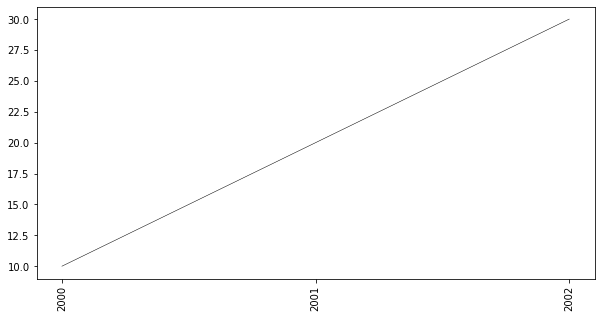

In [9]:
def my_figure():
    fig = plt.Figure(figsize=(10, 5))
    ax = fig.subplots()
    ax.plot([0, 1, 2], [10, 20, 30], '-k', linewidth=0.5)
    years = [2000, 2001, 2002]
    ax.set_xticks([0, 1, 2])
    ax.set_xticklabels(years)
    ax.tick_params(axis="x", labelrotation=90)
    print(type(ax))
    return fig


my_figure()

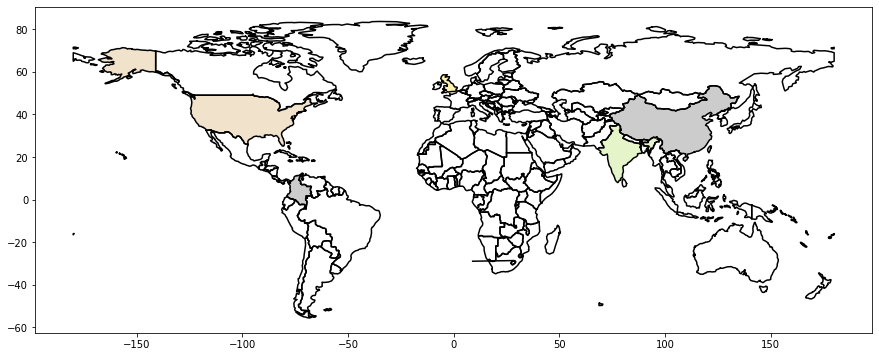

In [12]:
def worldmap(x, figsize=(10, 5), cmap="Pastel2", legend=True, *args, **kwargs):
    """Worldmap plot with the number of documents per country.

    Examples
    ----------------------------------------------------------------------------------------------

    >>> import pandas as pd
    >>> x = pd.DataFrame(
    ...     {
    ...         "AU_CO": ["China", "Taiwan", "United States", "United Kingdom", "India", "Colombia"],
    ...         "Num Documents": [1000, 900, 800, 700, 600, 1000],
    ...     },
    ... )
    >>> x
                AU_CO  Num Documents
    0           China           1000
    1          Taiwan            900
    2   United States            800
    3  United Kingdom            700
    4           India            600
    5        Colombia           1000


    >>> worldmap(x, figsize=(15, 6))
    >>> plt.savefig('sphinx/images/worldmap.png')

    .. image:: images/worldmap.png
        :width: 1500px
        :align: center


    """
    #module_path = dirname(__file__)
    fig = plt.Figure(figsize=figsize)
    ax = fig.subplots()
    x = x.copy()
    x["color"] = x[x.columns[1]].map(lambda w: w / x[x.columns[1]].max())
    x = x.set_index(x.columns[0])
    cmap = plt.cm.get_cmap(cmap)
    with open("worldmap.data", "r") as f:
        countries = json.load(f)
    for country in countries.keys():
        data = countries[country]
        for item in data:
            ax.plot(item[0], item[1], "-k")  # , linewidth=0.5
            if country in x.index.tolist():
                ax.fill(item[0], item[1], color=cmap(x.color[country]))
    #
    # xmin, xmax = plt.xlim()
    # ymin, ymax = plt.ylim()
    # xleft = xmax - 0.02 * (xmax - xmin)
    # xright = xmax
    # xbar = np.linspace(xleft, xright, 10)
    # ybar = np.linspace(ymin, ymin + (ymax - ymin), 100)
    # xv, yv = np.meshgrid(xbar, ybar)
    # z = yv / (ymax - ymin) - ymin
    # ax.pcolormesh(xv, yv, z, cmap=cmap)
    # ax.text(xleft, ymin, "0", ha="right")
    # ax.text(xleft, ymax, str(x[x.columns[0]].max()), ha="right")
    # ax.set_aspect("equal")
    # ax.axis("off")
    return fig


x = pd.DataFrame(
    {
        "AU_CO": ["China", "Taiwan", "United States", "United Kingdom", "India", "Colombia"],
        "Num Documents": [1000, 900, 800, 700, 600, 1000],
    },
)
worldmap(x, figsize=(15, 6))

In [ ]:
def my_figure():
    fig = plt.Figure()
    ax = fig.subplots()
    ax.plot([1, 2])
    return fig


my_figure()

In [ ]:
def my_figure():
    fig = plt.Figure()
    ax = fig.subplots()
    plt.gca().plot([1, 2])
    return fig


def my_figure2():
    fig = plt.Figure()
    ax = fig.subplots()
    ax.plot([2, 1])
    return fig


def basic_info():
    docs_by_year = widgets.Output()
    with docs_by_year:
        display(my_figure())

    citations_by_year = widgets.Output()
    with citations_by_year:
        display(my_figure2())

    accordion = widgets.Accordion(children=[docs_by_year, citations_by_year])
    accordion.set_title(0, "Documents by year")
    accordion.set_title(1, "Citations by year")
    return accordion


basic_info()

In [6]:
import ipywidgets as widgets
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import HTML, clear_output, display
from matplotlib.figure import Figure


def my_figure():
    fig = plt.Figure()
    ax = fig.subplots()
    ax.plot([1, 2])
    return fig


def my_figure2():
    fig = plt.Figure()
    ax = fig.subplots()
    ax.plot([2, 1])
    return fig


def basic_info():
    ##
    docs_by_year = widgets.Output()
    with docs_by_year:
        display(my_figure())
    ##
    citations_by_year = widgets.Output()
    with citations_by_year:
        display(my_figure2())
    ##
    table = widgets.Output()
    x = pd.DataFrame(0, columns=list("ABC"), index=list("abcde"))
    with table:
        display(x)
    ##
    tab = widgets.Tab()
    tab.children = [docs_by_year, citations_by_year, table]
    tab.set_title(0, "docs by year")
    tab.set_title(1, "citations by year")
    tab.set_title(2, "pandas")
    return tab


basic_info()

In [ ]:
my_figure()

In [3]:
tab_contents = ["P0", "P1", "P2", "P3", "P4"]
children = [widgets.Text(description=name) for name in tab_contents]
tab = widgets.Tab()
tab.children = children
tab.titles = [str(i) for i in range(len(children))]
tab

In [ ]:
#
# Number of terms
#
df.descriptive_stats()

# First Frequency Analysis

In [ ]:
#
# Documents by year
#
plt.figure(figsize=(10, 5))
Plot(df.documents_by_year()).bar(cmap=plt.cm.Greys)

In [ ]:
#
# Cumulative number of documents by year
#
plt.figure(figsize=(10, 5))
Plot(df.documents_by_year(cumulative=True)).bar(cmap=plt.cm.Greys)

In [ ]:
#
# Document Types
#
df.documents_by_term("Document Type")

In [ ]:
#
#  Most frequent authors
#
df.documents_by_term("Authors").head(10)

In [ ]:
#
# Top 10 most frequent authors
#
sorted(df.documents_by_term("Authors").head(10).Authors)

In [ ]:
#
#  Most frequent sources
#
df.documents_by_term("Source title").head(10)

In [ ]:
#
#  Most frequent institutions
#
df.documents_by_term("Institution").head(10)

In [ ]:
#
#  Most frequent countries
#
df.documents_by_term("Country").head(10)

In [ ]:
#
# Most frequent countries
#
plt.figure(figsize=(12, 5))
Plot(df.documents_by_term("Country", sep=";")).worldmap()
plt.show()

In [ ]:
#
#  Most frequent keywords
#
df.documents_by_term("Keywords").head(10)

# First level citation analysis

In [ ]:
#
# Most cited documents
#
df.most_cited_documents().head(10)

In [ ]:
#
# Top 10 most cited authors
#
df.citations_by_term("Authors").head(10)

In [ ]:
#
#  Most cited sources
#
df.citations_by_term("Source title").head(10)

In [ ]:
#
#  Most cited institutions
#
df.citations_by_term("Institution").head(10)

In [ ]:
#
#  Most cited countries
#
df.citations_by_term("Country", sep=";").head(10)

In [ ]:
#
# Most frequent countries
#
plt.figure(figsize=(12, 5))
Plot(df.citations_by_term("Country", sep=";")).worldmap()
plt.show()

In [ ]:
#
#  Most cited keywords
#
df.citations_by_term("Keywords").head(10)

# Second level frequency analysis

In [ ]:
#
# Top 10 frequent tems
#
top_10_freq_authors = Keywords(df.documents_by_term("Authors").head(10).Authors)
top_10_freq_sources = Keywords(
    df.documents_by_term("Source title").head(10)["Source title"]
)
top_10_freq_institutions = Keywords(
    df.documents_by_term("Institution", sep=";").head(10)["Institution"]
)
top_10_freq_country = Keywords(
    df.documents_by_term("Country", sep=";").head(10).Country
)
top_10_freq_keywords = Keywords(df.documents_by_term("Keywords").head(10).Keywords)

## Frequency by year

In [ ]:
df.documents_by_term_per_year("Authors", as_matrix=True, keywords=top_10_freq_authors)

In [ ]:
df.documents_by_term_per_year(
    "Source title", as_matrix=True, keywords=top_10_freq_sources
)

In [ ]:
df.documents_by_term_per_year(
    "Institution", sep=";", as_matrix=True, keywords=top_10_freq_institutions
)

In [ ]:
df.documents_by_term_per_year(
    "Country", sep=";", as_matrix=True, keywords=top_10_freq_country
)

In [ ]:
df.documents_by_term_per_year(
    "Keywords", sep=";", as_matrix=True, keywords=top_10_freq_keywords
)

## Occurrence Matrices

In [ ]:
plt.figure(figsize=(10, 10))
Plot(df.occurrence("Authors", as_matrix=True, keywords=top_10_freq_authors)).heatmap(
    cmap="Blues"
)

In [ ]:
#  df.occurrence('Source title', as_matrix=True, keywords=top_10_freq_sources)

In [ ]:
# df.occurrence('Institution', sep=';', as_matrix=True, keywords=top_10_freq_institutions)

In [ ]:
# df.occurrence('Country', sep=';', as_matrix=True, keywords=top_10_freq_country)

In [ ]:
#  df.occurrence('Keywords', as_matrix=True, keywords=top_10_freq_keywords)

## Autocorrelations

In [ ]:
Map().correlation_map(**df.autocorr_map("Authors", keywords=top_10_freq_authors))

In [ ]:
Map().correlation_map(
    **df.autocorr_map("Institution", keywords=top_10_freq_institutions)
)

In [ ]:
Map().correlation_map(
    **df.autocorr_map("Country", sep=";", keywords=top_10_freq_country)
)

In [ ]:
nxmap.correlation_map(
    **df.autocorr_map("Keywords", sep=";", keywords=top_10_freq_keywords)
)

## Factor Analysis

In [ ]:
df.factor_analysis("Authors", n_components=5, keywords=top_10_freq_authors)

In [ ]:
#  df.factor_analysis('Institutions', n_components=5, keywords = top_10_freq_institutions)

In [ ]:
#  df.factor_analysis('Countries', n_components=5, keywords = top_10_freq_institutions)

In [ ]:
#  df.factor_analysis('Keywords', n_components=5, keywords = top_10_freq_keywords)

# Gant Diagram

In [ ]:
plt.figure(figsize=(10, 6))
Plot(df.gant("Authors", keywords=top_10_freq_authors)).gant()

In [ ]:
plt.figure(figsize=(10, 6))
Plot(df.gant("Source title", keywords=top_10_freq_sources)).gant()

In [ ]:
plt.figure(figsize=(10, 6))
Plot(df.gant("Country", sep=";", keywords=top_10_freq_country)).gant()

In [ ]:
plt.figure(figsize=(10, 6))
Plot(df.gant("Keywords", sep=";", keywords=top_10_freq_keywords)).gant()

In [ ]:
import ipywidgets as widgets

In [ ]:
accordion = widgets.Accordion(children=[widgets.IntSlider(), widgets.Text()])
accordion.set_title(0, "Slider")
accordion.set_title(1, "Text")
accordion